In [1]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

In [2]:
import labrotation.file_handling as fh
import h5py
from time import time
import matplotlib.pyplot as plt
import numpy as np
import os
from labrotation import file_handling as fh
from copy import deepcopy
import pandas as pd
import labrotation.two_photon_session as tps

In [3]:
docu_folder = fh.open_dir("Choose folder containing folders for each mouse!")

In [4]:
mouse_folders = os.listdir(docu_folder)

In [5]:
matlab_2p_folder = fh.open_dir("Choose matlab-2p folder")

In [6]:
seg_fpath = os.path.join(docu_folder, mouse_folders[0], mouse_folders[0] + '_segmentation.xlsx')
grouping_fpath = os.path.join(docu_folder, mouse_folders[0], mouse_folders[0] + '_grouping.xlsx')
if os.path.exists(seg_fpath) and os.path.exists(grouping_fpath):
    print("Sounds right")
else:
    print("Check if you set the correct folder (folder containing all subfolders with mouse names)")

Sounds right


In [7]:
df_seg = pd.read_excel(seg_fpath)
df_grouping = pd.read_excel(grouping_fpath)

In [8]:
segments_dict = dict()

In [9]:
df_seg["nd2"].unique()

array(['T301_base_d1.180820.1614.nd2', 'T301_base_d1.180820.1636.nd2',
       'T301_baseline_d7.250820.1101.nd2', ...,
       'T301_tmev_d2.280820.1255.nd2', 'T301_tmev_d2.280820.1335.nd2',
       'T301_tmev_d2.280820.1439.nd2'], dtype=object)

In [10]:
# select only tmev experiment data first
df_grouping_tmev = df_grouping[df_grouping["experiment_type"] == "tmev"]

In [11]:
# take only recordings that were classified as "tmev" (experiment type)
df_seg.where(df_seg["nd2"].isin(df_grouping_tmev["nd2"].unique()), inplace=True)
# wrong experiment type recordings changed to NaN; drop them
df_seg.dropna(inplace=True)

In [12]:
# take only videos with seizure
df_seg = df_seg.groupby("nd2").filter(lambda group: "sz" in group["interval_type"].unique())

In [13]:
# change labels of segments that start the video until seizure as "baseline"
df_seg.loc[(df_seg["interval_type"] == "normal") & (df_seg["frame_begin"] == 1.0), "interval_type"] = "baseline"

In [14]:
df_seg

,nd2,interval_type,frame_begin,frame_end
8,T301_tmev_d1.270820.1151.nd2,baseline,1.0,8672.0
9,T301_tmev_d1.270820.1151.nd2,sz,8673.0,9147.0
10,T301_tmev_d1.270820.1151.nd2,sd_wave,9148.0,9301.0
11,T301_tmev_d1.270820.1151.nd2,sd_extinction,9302.0,10307.0
12,T301_tmev_d1.270820.1151.nd2,normal,10308.0,16485.0
13,T301_tmev_d1.270820.1209.nd2,baseline,1.0,6844.0
14,T301_tmev_d1.270820.1209.nd2,sz,6845.0,7396.0
15,T301_tmev_d1.270820.1209.nd2,sd_wave,7397.0,7587.0
16,T301_tmev_d1.270820.1209.nd2,sd_extinction,7588.0,8670.0
17,T301_tmev_d1.270820.1209.nd2,normal,8671.0,16447.0


In [15]:
# 3. open 2psession for each nd2, do matching. Need nd2? or only nd2 meta + labview. Latter would be much quicker.

In [16]:
grouping_data = df_grouping_tmev[df_grouping_tmev["nd2"] == df_seg.iloc[0]["nd2"]]
labview_fpath = os.path.join(grouping_data["folder"].iloc[0], grouping_data["labview"].iloc[0])
nikmeta_fpath = os.path.join(grouping_data["folder"].iloc[0], grouping_data["nikon_meta"].iloc[0])

In [17]:
ses = tps.TwoPhotonSession(nd2_timestamps_path=nikmeta_fpath, labview_path=labview_fpath, matlab_2p_folder=matlab_2p_folder)

In [18]:
ses.infer_labview_timestamps()

Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\tmev\T301\T301_tmev_d1\T301_tmev_d1.270820.1151time.txt


In [19]:
ses._open_data()  # TODO: implement a better way than using "private" function

Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\tmev\T301\T301_tmev_d1
	T301_tmev_d1.270820.1151
	T301_tmev_d1.270820.1151_nik
No conversion of belt_length_mm happened, as belt_params['belt_length_mm'] is type <class 'float'>


In [20]:
ses_segments = df_seg[df_seg["nd2"]==df_seg.iloc[0]["nd2"]]

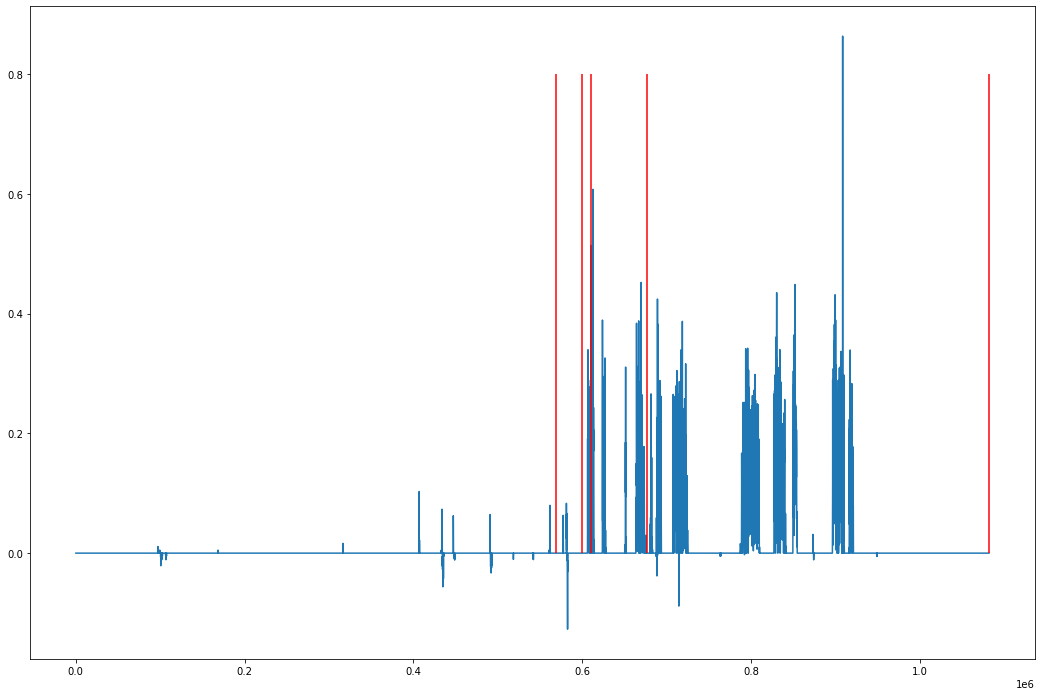

In [21]:
fig = plt.figure(figsize=(18,12))
plt.plot(ses.belt_scn_dict["tsscn"], ses.belt_scn_dict["speed"])
for interval in ses_segments["frame_end"]:
    plt.vlines(x=ses.belt_scn_dict["tsscn"][int(interval)-1], ymin=0, ymax=0.8, color="red")
plt.show()

In [22]:
ses.belt_scn_dict.keys()

dict_keys(['tsscn', 'rounds', 'speed', 'distance', 'totdist', 'running'])

In [ ]:
ses.belt_scn_dict["speed"]

In [ ]:
# think about data to quantify (integrated velocity/distance per interval? divided by interval length)
# maybe need nd2 to extract mean, check if zones correspond to imaging data

In [ ]:
for index, row in ses_segments.iterrows():
    t0 = int(row["frame_begin"] - 1)  # correct 1-indexing to 0-indexing, convert to int
    t1 = int(row["frame_end"])  # list[a:b] returns elements a to (b-1), so no need to subtract here
    if row["interval_type"] not in segments_dict.keys():
        segments_dict[row["interval_type"]] = []
    segments_dict[row["interval_type"]].append(deepcopy(ses.belt_scn_dict["speed"][t0:t1]))